## Rewriting to take data a bit more neatly

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as ticker
import pandas as pd
# import stuff
import sys,os,os.path

sys.path.append("/home/e78368jw/Documents/NEXT_CODE/next_misc/")
import core.functions as func

ModuleNotFoundError: No module named 'tqdm'

In [72]:
def plot_2Dhist(ND_array, xlabel, ylabel, title = '2D Histogram', xlabel_title = 'x axis', ylabel_title = 'y axis', vmin = None, vmax = None, inverse = False):
    '''
    ND_array -> input array of NxN dimensions. MAKE SURE ITS NUMPY HSTACKED ARRAY
    xlabel   -> x label list
    ylabel   -> y label list

    To make array suitable for input use function similar to this:
    array = np.hstack((array_1, array_2, array_3, array_4, array_5, array_6)).reshape(-1,array_1.shape[0])
    '''


    nx, ny = ND_array.shape

    indx, indy = np.arange(ny), np.arange(nx)
    x, y = np.meshgrid(indx, indy, indexing='ij')

    fig, ax = plt.subplots()

    if inverse:
        ax.imshow((1 - ND_array), interpolation="none", vmin=vmin, vmax=vmax)    
    else:
        ax.imshow(ND_array, interpolation="none", vmin=vmin, vmax=vmax)

    # take 50% point of FOM values and make text white if met
    flip_val = np.nanmin(ND_array) + ((np.nanmax(ND_array) - np.nanmin(ND_array)) / 2)

    for xval, yval in zip(y.flatten(), x.flatten()):
        zval = ND_array[xval, yval]
        t = zval # format value with 1 decimal point
        if inverse:
            c = 'k' if zval < flip_val else 'w' # if dark-green, change text color to white
        else:
            c = 'k' if zval > flip_val else 'w' # if dark-green, change text color to white
        
        ax.text(yval, xval, t, color=c, va='center', ha='center')


    xlabels = xlabel
    ylabels = ylabel

    ax.set_xticks(indx+0.5) # offset x/y ticks so gridlines run on border of boxes
    ax.set_yticks(indy+0.5)
    ax.grid(ls='-', lw=2)
    ax.set_xlabel(xlabel_title)
    ax.set_ylabel(ylabel_title)
    ax.set_title(title)

    # the tick labels, if you want them centered need to be adjusted in 
    # this special way.
    for a, ind, labels in zip((ax.xaxis, ax.yaxis), (indx, indy), 
                            (xlabels, ylabels)):
        a.set_major_formatter(ticker.NullFormatter())
        a.set_minor_locator(ticker.FixedLocator(ind))
        a.set_minor_formatter(ticker.FixedFormatter(labels))

    ax.xaxis.tick_top()

# It works! Functionalise
def scrape_FOM_data(data_path):

    # collect data
    hold = pd.HDFStore(data_path)
    store = hold.keys()
    hold.close()

    # sanitise
    remove = [x.replace("/", "") for x in store]
    split = [(x.split("_")) for x in remove]

    # collect all unique first elements (n_iter)
    unique_0s = list(set([x[0] for i, x in enumerate(split)]))
    # and second elements
    unique_1s = list(set([x[1] for i, x in enumerate(split)]))

    # organise and add leading zero to column (1s)
    unique_0s_ = sorted(unique_0s, key=float)
    unique_1s_ = sorted(unique_1s, key=float)
    unique_1s_ = ["n_iter"] + unique_1s_
    
    # create pandas dataframe with these as the axis
    df = pd.DataFrame(columns = unique_1s_)
    
    # start adding rows babee
    for i in range(len(unique_0s_)):
    	df.loc[i] = [unique_0s_[i]] + list(np.full(shape=len(unique_1s), fill_value=np.nan))

    # set it as the index as well
    df.set_index('n_iter', inplace=True)
    
    # collect the data from each table in the h5 dataframe
    for i in range(len(store)):
        # reformat store data to allow for correct indexing
        remove = store[i].replace("/", "")
        split = remove.split("_")

        play_thing = pd.read_hdf(data_path,key=store[i])
        play_thing.set_index('Cut', inplace=True)
        fom_val = play_thing.loc['FOM_MAX - blob2_E_val (MeV)', 'Relative Efficiency']
            
        df.at[split[0], split[1]] = fom_val
	
    fom_list = []
    for i in range(len(df.index)):
        fom_list.append(df.loc[df.index[i]].to_numpy())
    
    fom_list = np.array(fom_list)
    #reshape into x,y array
    x_vals = (df.columns).to_list()
    y_vals = (df.index).to_list()
    
    # set nans to zeros
    fom_list[np.isnan(fom_list.astype(float))] = 0
    
    fom_list = np.round(fom_list.astype(float), decimals=2)
    
    plot_2Dhist(fom_list, x_vals, y_vals, title = 'FOM LPR', xlabel_title = 'e_cut', ylabel_title = 'number of iterations')
    

## PSCAN 040625

In [51]:
# scanR
xlabel = ['30', '40', '50', '60']
# blobR
ylabel = ['25', '35', '45', '55']

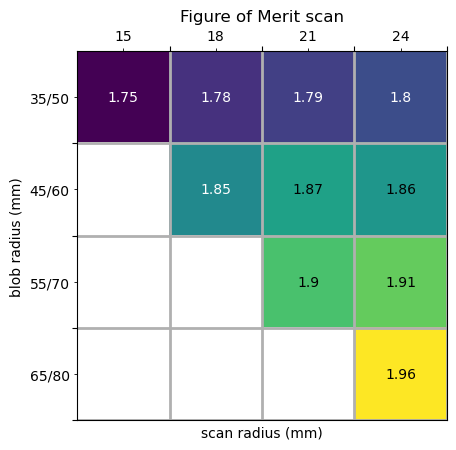

In [73]:
# FOM array
FOM = np.array([[1.75, 1.78, 1.79, 1.8], [0.0, 1.85, 1.87, 1.86], [0.0, 0.0, 1.9, 1.91], [0.0, 0.0, 0.0, 1.96]])
FOM[FOM == 0.0] = np.nan

plot_2Dhist(FOM, xlabel, ylabel, title = 'Figure of Merit scan', xlabel_title = 'scan radius (mm)', ylabel_title = 'blob radius (mm)')

69.52
80.98
11.460000000000008
5.730000000000004
75.25


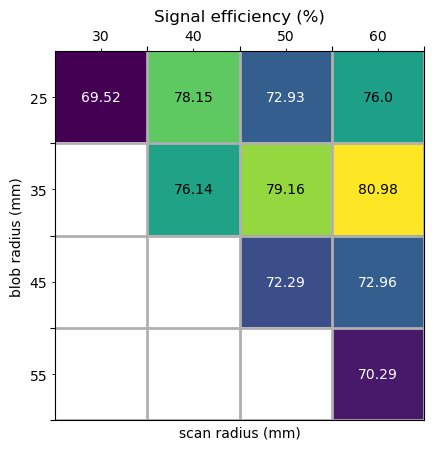

In [53]:
# Signal efficiency
se = np.array([[69.52, 78.15, 72.93, 76.0],
                [np.nan, 76.14, 79.16, 80.98],
                [np.nan, np.nan, 72.29, 72.96],
                [np.nan, np.nan, np.nan, 70.29]])
se[se == 0.0] = np.nan

plot_2Dhist(se, xlabel, ylabel, title = 'Signal efficiency (%)', xlabel_title = 'scan radius (mm)', ylabel_title = 'blob radius (mm)')

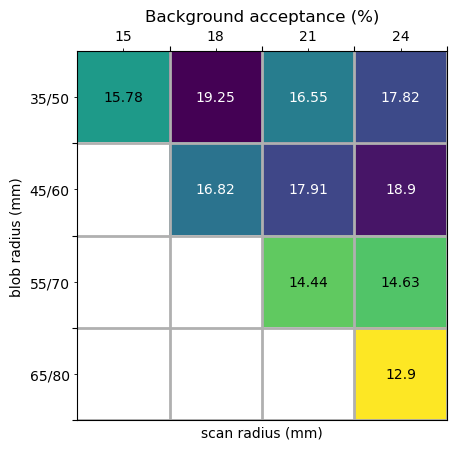

In [74]:
# Background acceptance
ba = np.array([[15.78, 19.25, 16.55, 17.82],
                [np.nan, 16.82, 17.91, 18.90],
                [np.nan, np.nan, 14.44, 14.63],
                [np.nan, np.nan, np.nan, 12.90]])
ba[ba == 0.0] = np.nan

plot_2Dhist(ba, xlabel, ylabel, title = 'Background acceptance (%)', xlabel_title = 'scan radius (mm)', ylabel_title = 'blob radius (mm)', inverse = True)

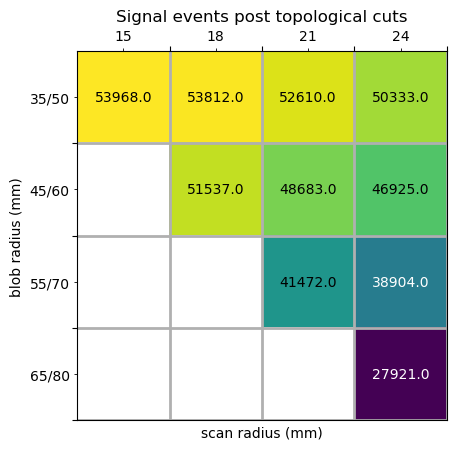

In [80]:
# initial signal events
# Background acceptance
ise = np.array([[53968, 53812, 52610, 50333],
                [np.nan, 51537, 48683, 46925],
                [np.nan, np.nan, 41472, 38904],
                [np.nan, np.nan, np.nan, 27921]])
ise[ise == 0.0] = np.nan

plot_2Dhist(ise, xlabel, ylabel, title = 'Signal events post topological cuts', xlabel_title = 'scan radius (mm)', ylabel_title = 'blob radius (mm)')

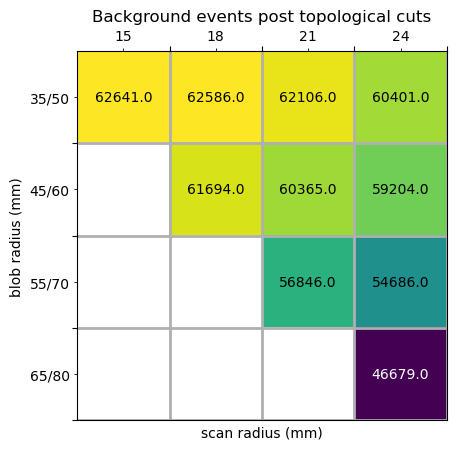

In [79]:
# initial background events

ibe = np.array([[62641, 62586, 62106, 60401],
                [0, 61694, 60365, 59204],
                [0, 0, 56846, 54686],
                [0, 0, 0, 46679]], dtype=int)
ibe = ibe.astype(float)
ibe[ibe == 0] = np.nan


plot_2Dhist(ibe, xlabel, ylabel, title = 'Background events post topological cuts', xlabel_title = 'scan radius (mm)', ylabel_title = 'blob radius (mm)')

## PSCAN 209825
its meant to be 200825 but mistyped

In [55]:
# voxelsize
xlabel = ['15', '18', '21', '24']
# blobR & scanR
ylabel = ['35/50', '45/60', '55/70', '65/80']

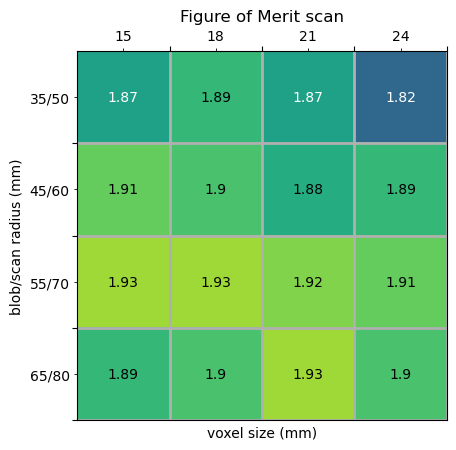

In [68]:
# FOM array
FOM = np.array([[1.87, 1.89, 1.87, 1.82], 
                [1.91, 1.9, 1.88, 1.89], 
                [1.93, 1.93, 1.92, 1.91], 
                [1.89, 1.9, 1.93, 1.9]])
FOM[FOM == 0.0] = np.nan

plot_2Dhist(FOM, xlabel, ylabel, title = 'Figure of Merit scan', xlabel_title = 'voxel size (mm)', ylabel_title = 'blob/scan radius (mm)', vmin = 1.75, vmax = 1.96)

62.32
79.16
16.839999999999996
8.419999999999998
70.74


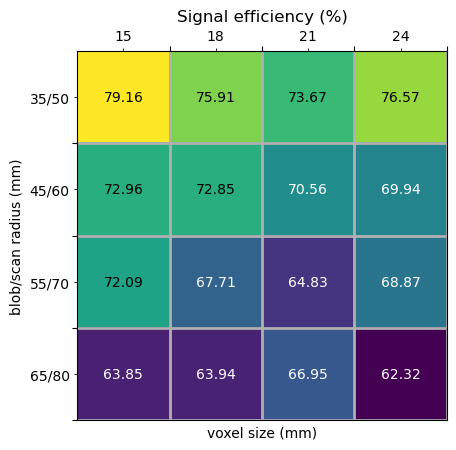

In [57]:
# Signal efficiency
se = np.array([[79.16, 75.91, 73.67, 76.57],
                [72.96, 72.85, 70.56, 69.94],
                [72.09, 67.71, 64.83, 68.87],
                [63.85, 63.94, 66.95, 62.32]])
se[se == 0.0] = np.nan

plot_2Dhist(se, xlabel, ylabel, title = 'Signal efficiency (%)', xlabel_title = 'voxel size (mm)', ylabel_title = 'blob/scan radius (mm)')

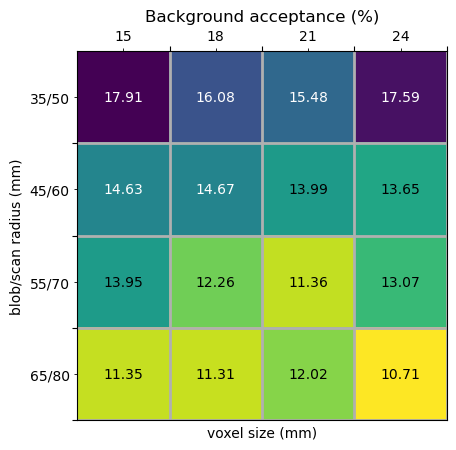

In [75]:
# Background acceptance
ba = np.array([[17.91, 16.08, 15.48, 17.59],
                [14.63, 14.67, 13.99, 13.65],
                [13.95, 12.26, 11.36, 13.07],
                [11.35, 11.31, 12.02, 10.71]])
ba[ba == 0.0] = np.nan

plot_2Dhist(ba, xlabel, ylabel, title = 'Background acceptance (%)', xlabel_title = 'voxel size (mm)', ylabel_title = 'blob/scan radius (mm)', inverse = True)

### OLD PLOTS

0.0
3.6
3.6
1.8
1.8


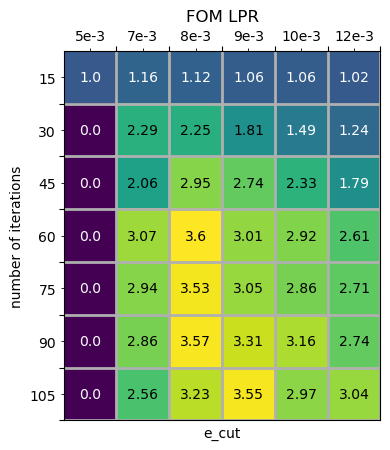

In [59]:
scrape_FOM_data('../../../../Downloads/tmp_out/testing_arena/fiducial_0_1a.h5')

0.0
3.6
3.6
1.8
1.8


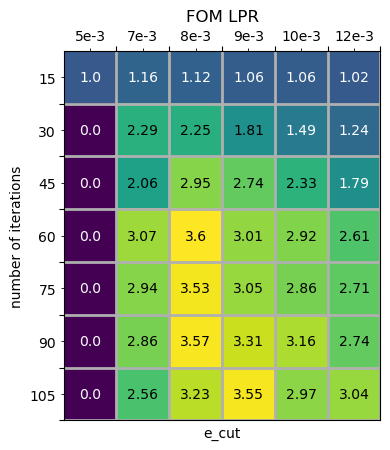

In [60]:
scrape_FOM_data('../../../../Downloads/tmp_out/testing_arena/fiducial_0_1a.h5')

THIS ONE IS THE PORT_1A OLD CUTS FOR COMPARISON


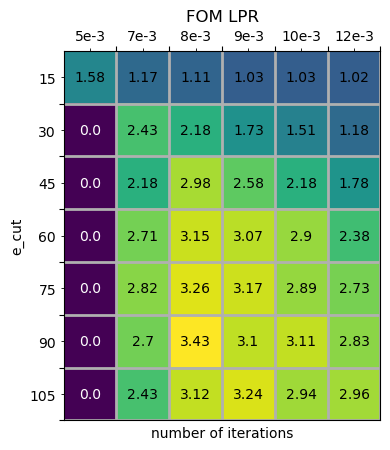

In [5]:
scrape_FOM_data('../../../../Downloads/tmp_out/testing_arena/fiducial.h5')
print("THIS ONE IS THE PORT_1A OLD CUTS FOR COMPARISON")

NEW FIDUCIAL


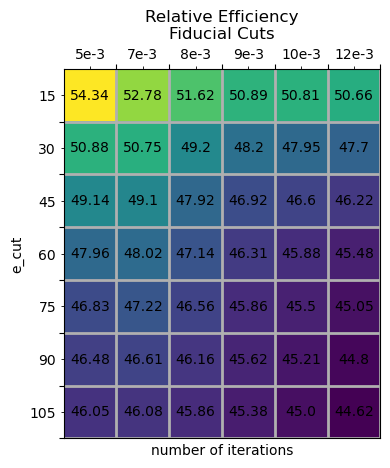

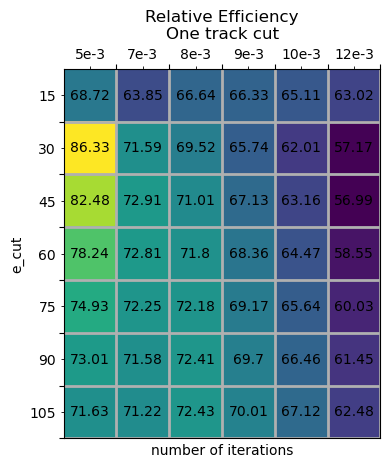

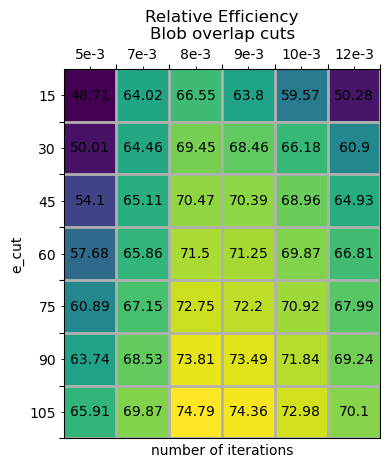

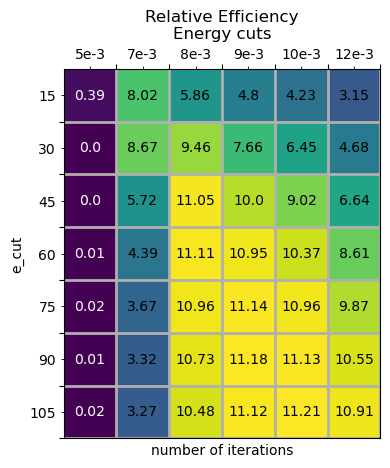

In [6]:
test_data = '../../../../Downloads/tmp_out/testing_arena/fiducial_0_1a.h5'
test_data_old = '../../../../Downloads/tmp_out/testing_arena/fiducial.h5'

print("NEW FIDUCIAL")
scrape_any_data(test_data,'Fiducial Cuts' , 'Relative Efficiency', 'Relative Efficiency\nFiducial Cuts')
scrape_any_data(test_data,'One track cut' , 'Relative Efficiency', 'Relative Efficiency\nOne track cut')
scrape_any_data(test_data,'Blob overlap cuts' , 'Relative Efficiency', 'Relative Efficiency\nBlob overlap cuts')
scrape_any_data(test_data,'Energy cuts' , 'Relative Efficiency', 'Relative Efficiency\nEnergy cuts')

#print("OLD FIDUCIAL")
#scrape_any_data(test_data_old,'Fiducial Cuts' , 'Relative Efficiency', 'Relative Efficiency\nFiducial Cuts')

### Comparing the ports:

### OLD PLOTS

PORT: 1A
PORT: 1B
PORT: 2A


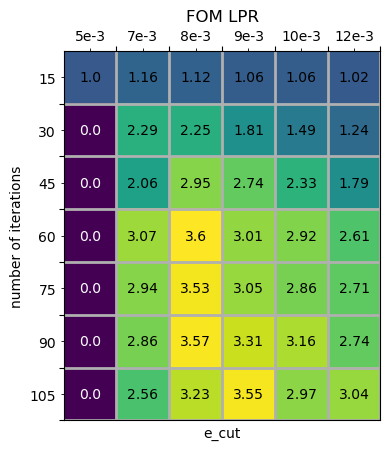

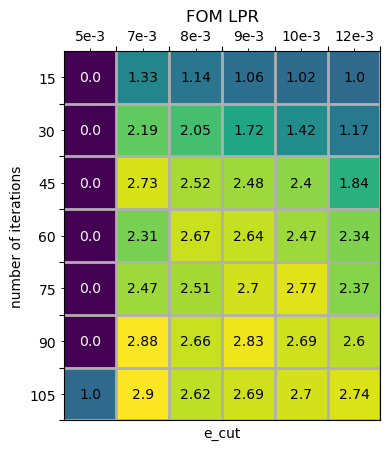

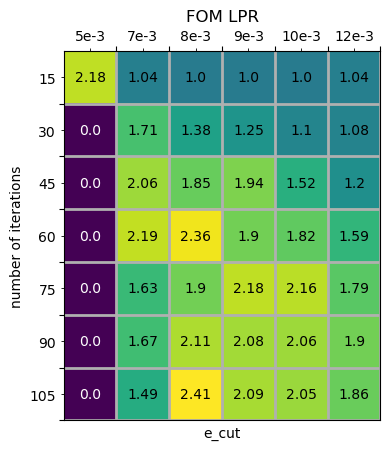

In [3]:
print("========================================================")
print("PORT: 1A")
print("========================================================")
scrape_FOM_data('../../../../Downloads/tmp_out/testing_arena/fiducial_0_1a.h5')
print("========================================================")
print("PORT: 1B")
print("========================================================")
scrape_FOM_data('../../../../Downloads/tmp_out/testing_arena/fiducial_0_1b.h5')
print("========================================================")
print("PORT: 2A")
print("========================================================")
scrape_FOM_data('../../../../Downloads/tmp_out/testing_arena/fiducial_0_2a.h5')

PORT: 1A
PORT: 1B
PORT: 2A


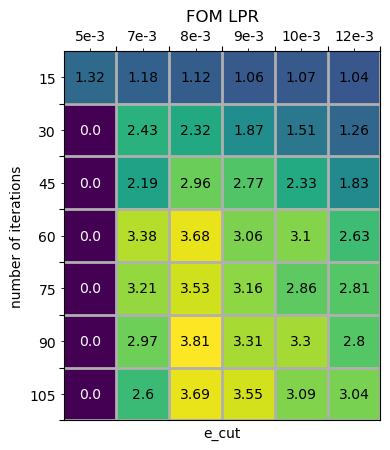

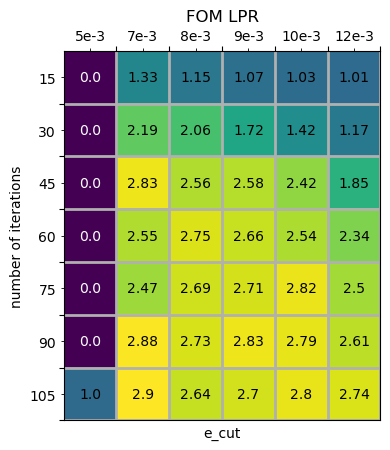

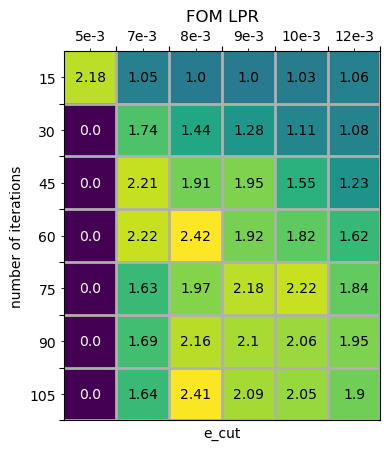

In [4]:
print("========================================================")
print("PORT: 1A")
print("========================================================")
scrape_FOM_data('../../../../Downloads/tmp_out/testing_arena/fiducial_0_1a_new.h5')
print("========================================================")
print("PORT: 1B")
print("========================================================")
scrape_FOM_data('../../../../Downloads/tmp_out/testing_arena/fiducial_0_1b_new.h5')
print("========================================================")
print("PORT: 2A")
print("========================================================")
scrape_FOM_data('../../../../Downloads/tmp_out/testing_arena/fiducial_0_2a_new.h5')

In [3]:
#data_paths =    ['../../../../Downloads/tmp_out/testing_arena/fiducial_0_1a_new.h5',
#                '../../../../Downloads/tmp_out/testing_arena/fiducial_0_1b_new.h5',
#                '../../../../Downloads/tmp_out/testing_arena/fiducial_0_2a_new.h5',
#                '../../../../Downloads/tmp_out/testing_arena/fiducial_1_2b_new.h5']

data_paths =    ['fom_data/fiducial_1a.h5',
                 'fom_data/fiducial_1b.h5',
                 'fom_data/fiducial_2a.h5',
                 'fom_data/fiducial_2b.h5',]

1a
1b
2a
2b


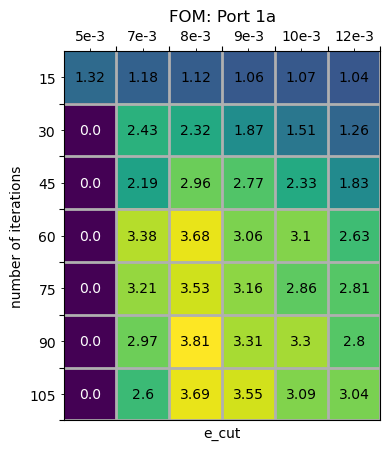

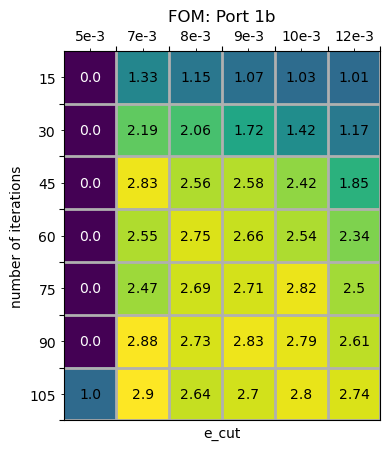

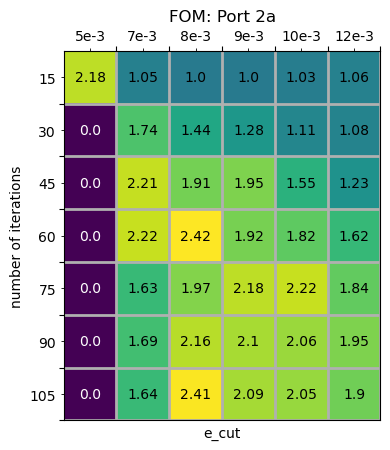

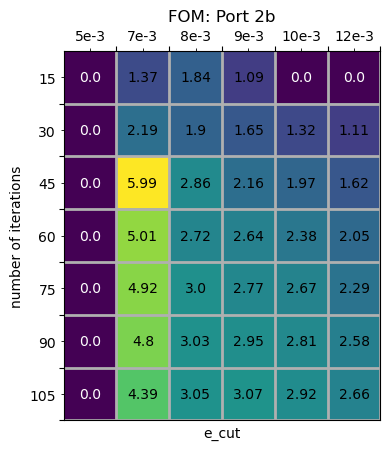

In [4]:
for i in range(len(data_paths)):
    name = data_paths[i].split("/")[-1][:-3]
    name = name[9:]
    name2 = "Port " + name
    print(name)
    func.scrape_any_data(data_paths[i], 'FOM_MAX - blob2_E_val (MeV)', 'Relative Efficiency', plot_title = "FOM: " + name2)

1a
1b
2a
2b


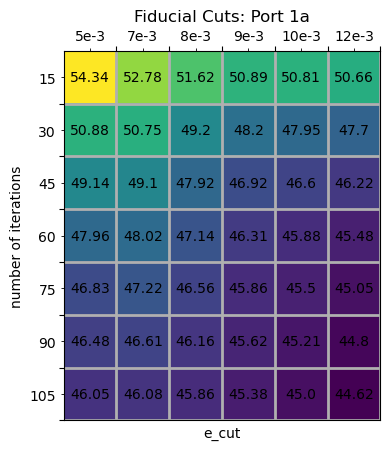

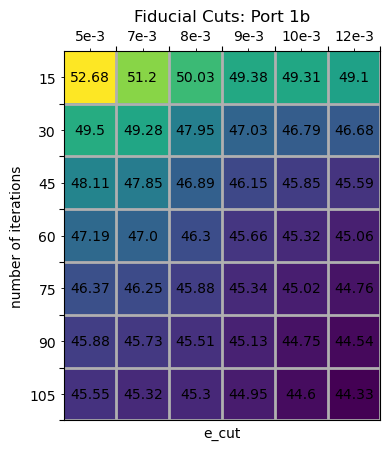

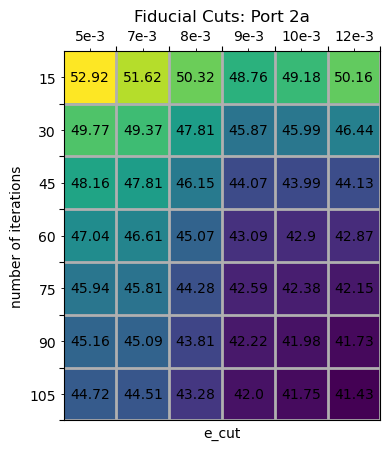

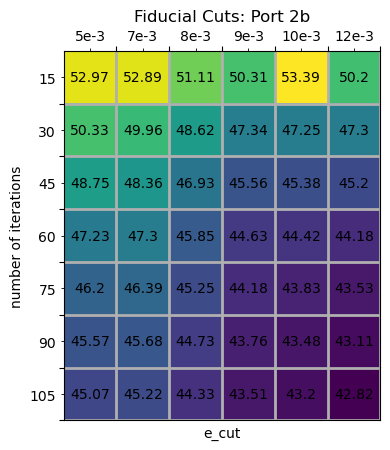

In [5]:
for i in range(len(data_paths)):
    name = data_paths[i].split("/")[-1][:-3]
    name = name[9:]
    name2 = "Port " + name
    print(name)
    func.scrape_any_data(data_paths[i], 'Fiducial Cuts', 'Relative Efficiency', plot_title = "Fiducial Cuts: " + name2)

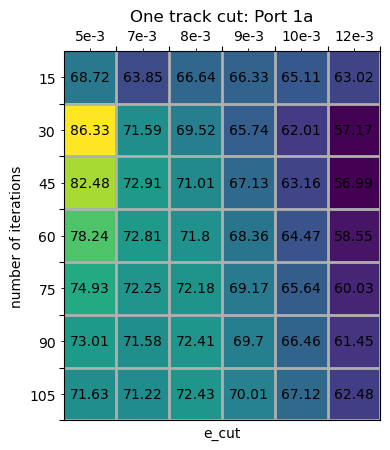

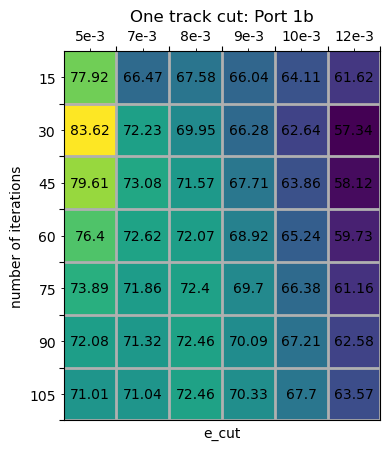

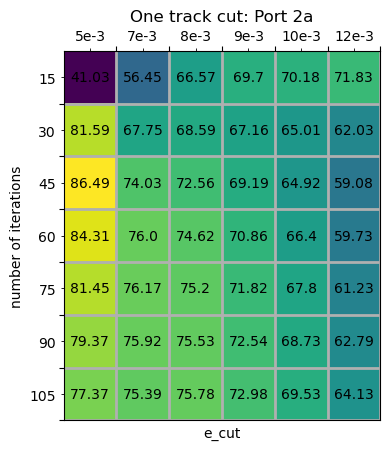

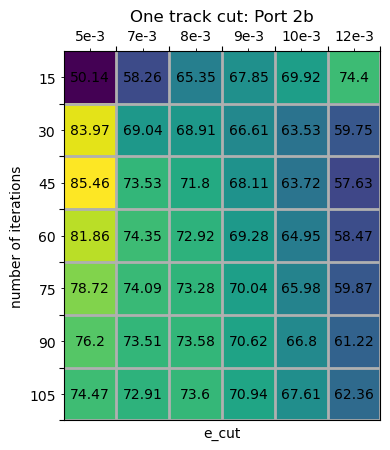

In [6]:
for i in range(len(data_paths)):
    name = data_paths[i].split("/")[-1][:-3]
    name = name[9:]
    name2 = "Port " + name
    func.scrape_any_data(data_paths[i], 'One track cut', 'Relative Efficiency', plot_title = "One track cut: " + name2)

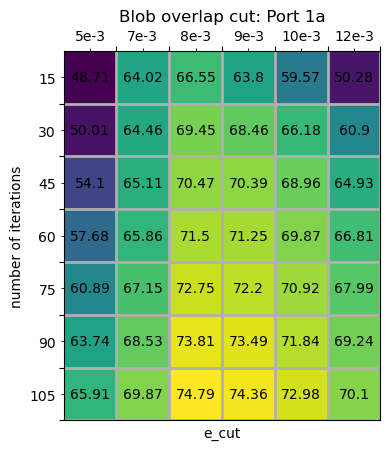

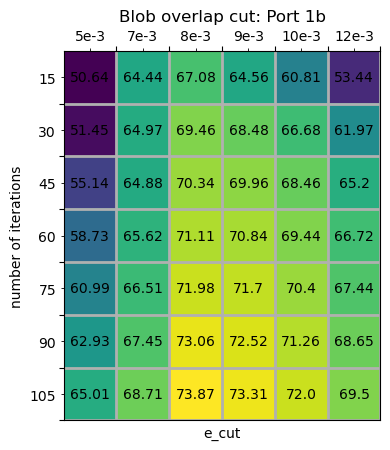

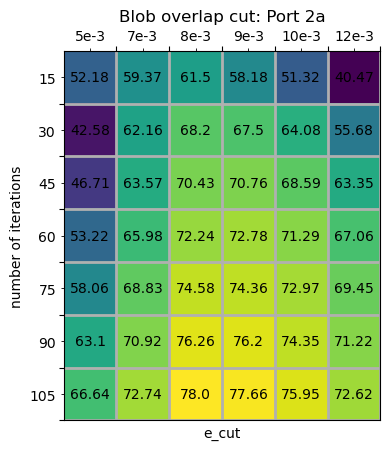

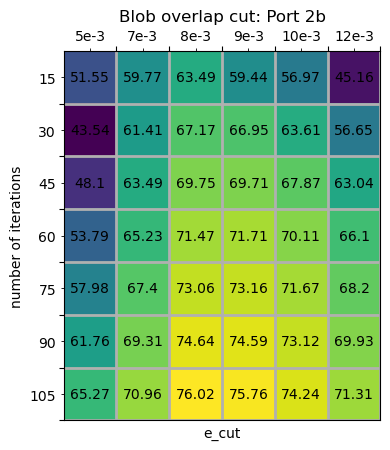

In [7]:
for i in range(len(data_paths)):
    name = data_paths[i].split("/")[-1][:-3]
    name = name[9:]
    name2 = "Port " + name
    func.scrape_any_data(data_paths[i], 'Blob overlap cuts', 'Relative Efficiency', plot_title = "Blob overlap cut: " + name2)

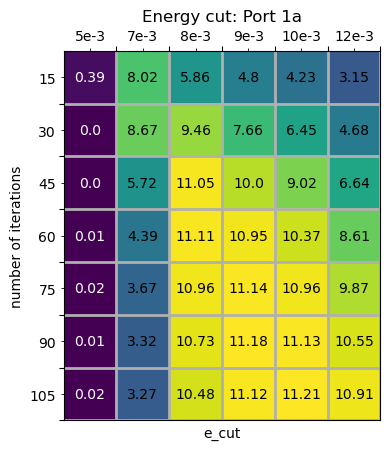

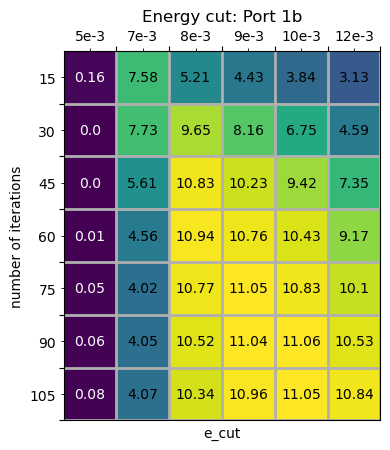

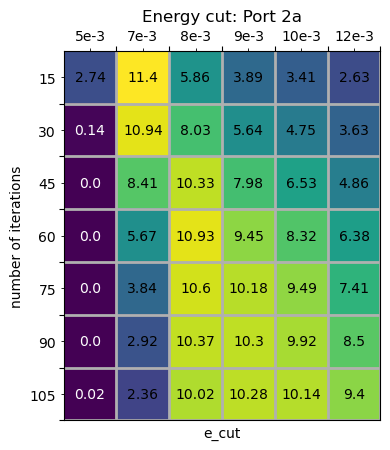

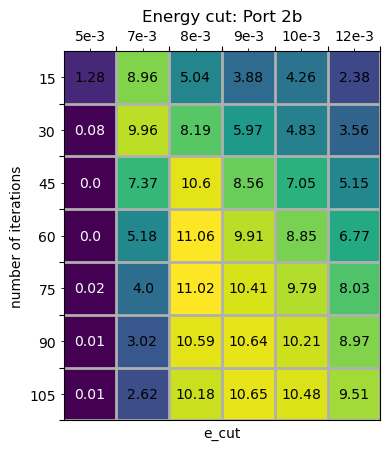

In [8]:
for i in range(len(data_paths)):
    name = data_paths[i].split("/")[-1][:-3]
    name = name[9:]
    name2 = "Port " + name
    func.scrape_any_data(data_paths[i], 'Energy cuts', 'Relative Efficiency', plot_title = "Energy cut: " + name2)

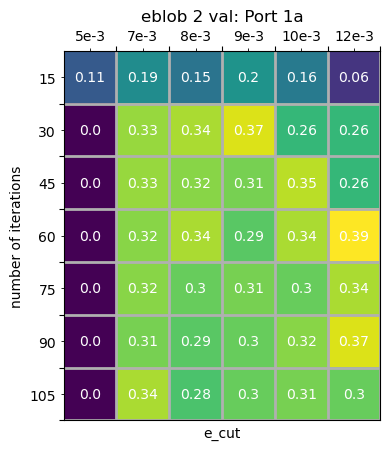

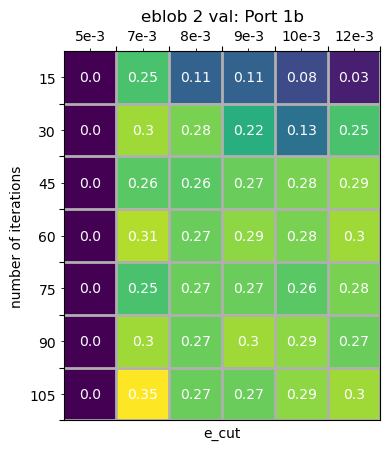

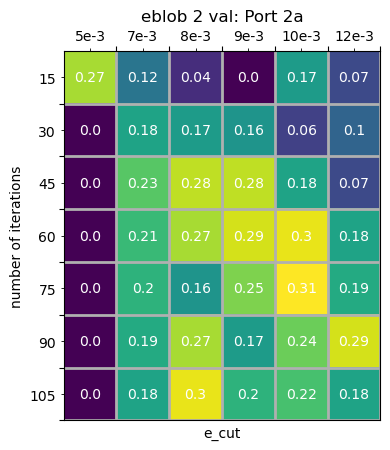

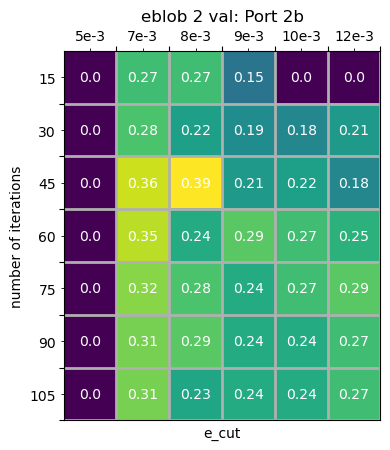

In [9]:
for i in range(len(data_paths)):
    name = data_paths[i].split("/")[-1][:-3]
    name = name[9:]
    name2 = "Port " + name
    func.scrape_any_data(data_paths[i], 'FOM_MAX - blob2_E_val (MeV)', 'Relative Events', plot_title = "eblob 2 val: " + name2)

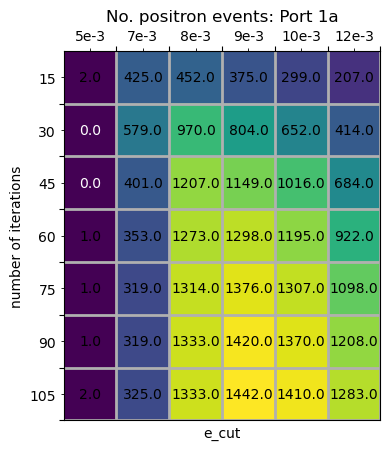

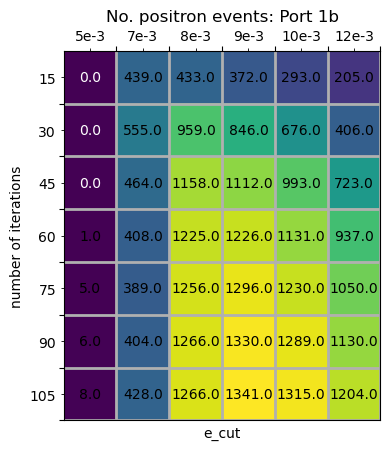

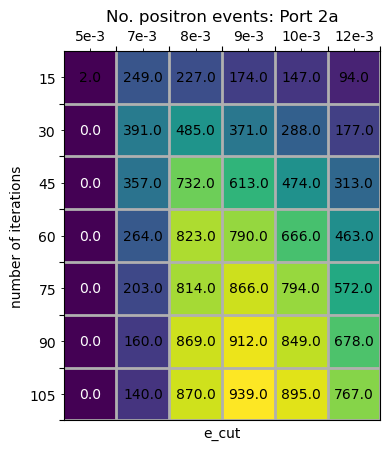

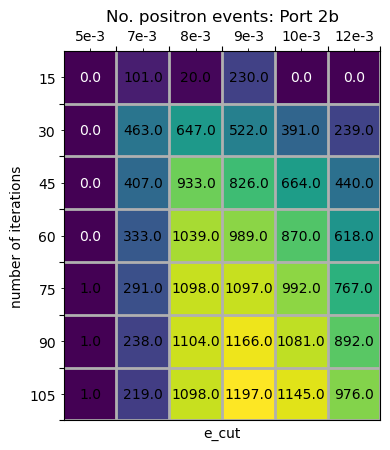

In [10]:
for i in range(len(data_paths)):
    name = data_paths[i].split("/")[-1][:-3]
    name = name[9:]
    name2 = "Port " + name
    func.scrape_any_data(data_paths[i], 'pos_evt - all_evt', 'Relative Efficiency', plot_title = "No. positron events: " + name2)

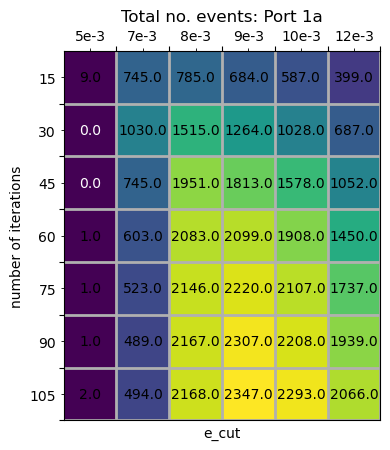

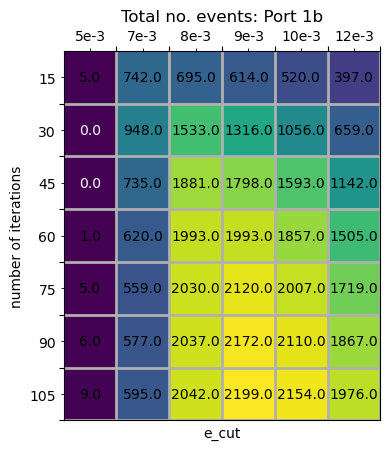

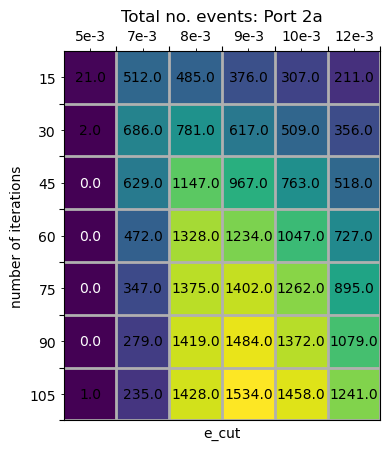

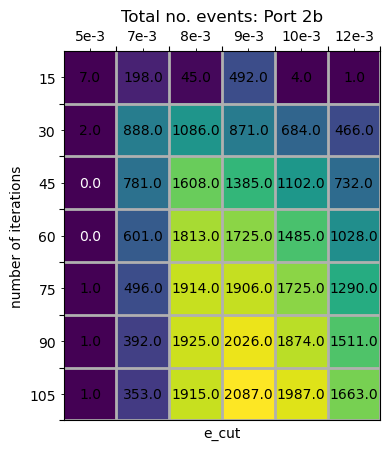

In [12]:
for i in range(len(data_paths)):
    name = data_paths[i].split("/")[-1][:-3]
    name = name[9:]
    name2 = "Port " + name
    func.scrape_any_data(data_paths[i], 'pos_evt - all_evt', 'Relative Events', plot_title = "Total no. events: " + name2)

In [13]:

# this one differs, it allows you to scrape any data and make a 2D FOM plot
def scrape_any_data_new(data_path, string_1, string_2, plot_title):
    '''
    Similar to function 'scrape_FOM_data', 
    but works with any row and column from efficiency h5 file.

    Args:
        data_path           :           data path leading to relevant h5 file
        string_1            :           row of interest
        string_2            :           column of interest
        plot_title          :           plot title
    
    Returns:
        None                :           empty return
    '''

    # collect data
    hold = pd.HDFStore(data_path)
    store = hold.keys()
    hold.close()
    # sanitise
    remove = [x.replace("/", "") for x in store]
    split = [(x.split("_")) for x in remove]

    # collect all unique first elements (n_iter)
    unique_0s = list(set([x[0] for i, x in enumerate(split)]))
    # and second elements
    unique_1s = list(set([x[2] for i, x in enumerate(split)]))

    # organise and add leading zero to column (1s)
    unique_0s_ = sorted(unique_0s, key=float)
    unique_1s_ = sorted(unique_1s, key=float)
    unique_1s_ = ["voxel size"] + unique_1s_
    
    #print(unique_0s_)
    #print(unique_1s_)

    # create pandas dataframe with these as the axis
    df = pd.DataFrame(columns = unique_1s_)
    
    # start adding rows babee
    for i in range(len(unique_0s_)):
    	df.loc[i] = [unique_0s_[i]] + list(np.full(shape=len(unique_1s), fill_value=np.nan))



    # set it as the index as well
    df.set_index('voxel size', inplace=True)
    
    
    # collect the data from each table in the h5 dataframe
    for i in range(len(store)):
        # reformat store data to allow for correct indexing
        remove = store[i].replace("/", "")
        split = remove.split("_")

        play_thing = pd.read_hdf(data_path,key=store[i])
        play_thing.set_index('Cut', inplace=True)
        fom_val = play_thing.loc[str(string_1), str(string_2)]
        
        #print(fom_val)
        df.at[split[0], split[2]] = fom_val
	
    fom_list = []
    for i in range(len(df.index)):
        fom_list.append(df.loc[df.index[i]].to_numpy())
    
    fom_list = np.array(fom_list)
    #reshape into x,y array
    x_vals = (df.columns).to_list()
    y_vals = (df.index).to_list()
    
    # set nans to zeros
    fom_list[np.isnan(fom_list.astype(float))] = 0
    
    fom_list = np.round(fom_list.astype(float), decimals=2)

    plot_2Dhist(fom_list, x_vals, y_vals, title = str(plot_title), xlabel_title = 'blobR', ylabel_title = 'voxel size')


fiducial_isaur


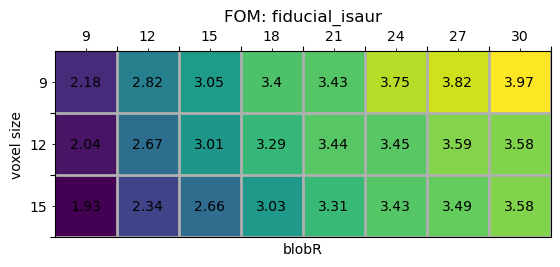

In [14]:
data_groups = ["../../../../Downloads/tmp_out/testing_arena/fiducial_isaura_1a.h5", 
               "../../../../Downloads/tmp_out/testing_arena/fiducial_isaura_1b.h5", 
               "../../../../Downloads/tmp_out/testing_arena/fiducial_isaura_2a.h5",
               "../../../../Downloads/tmp_out/testing_arena/fiducial_isaura_2b.h5"]

data_new_isaura = "../../../../Downloads/tmp_out/testing_arena/fiducial_isaura_1a.h5"
name = data_new_isaura.split("/")[-1][:-7]
print(name)
scrape_any_data_new(data_new_isaura, 'FOM_MAX - blob2_E_val (MeV)', 'Relative Efficiency', plot_title = "FOM: " + name)

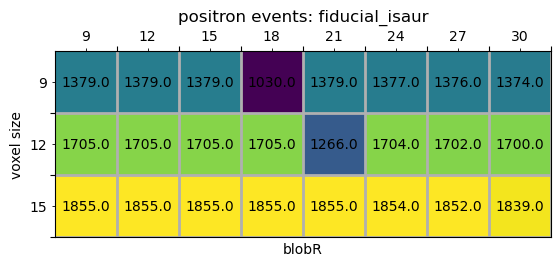

In [6]:
scrape_any_data_new(data_new_isaura, 'pos_evt - all_evt', 'Relative Efficiency', plot_title = "positron events: " + name)

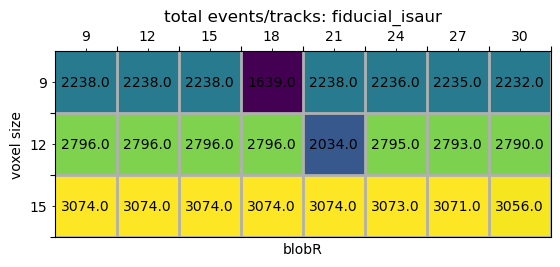

In [8]:
scrape_any_data_new(data_new_isaura, 'pos_evt - all_evt', 'Relative Events', plot_title = "total events/tracks: " + name)

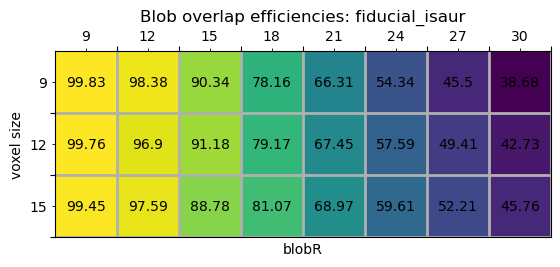

In [12]:
scrape_any_data_new(data_new_isaura, 'Blob overlap cuts', 'Relative Efficiency', plot_title = "Blob overlap efficiencies: " + name)

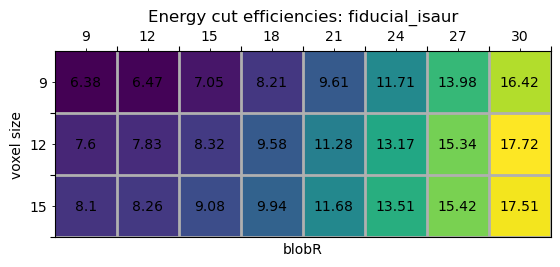

In [13]:
scrape_any_data_new(data_new_isaura, 'Energy cuts', 'Relative Efficiency', plot_title = "Energy cut efficiencies: " + name)

1a
1b


ValueError: not enough values to unpack (expected 2, got 1)

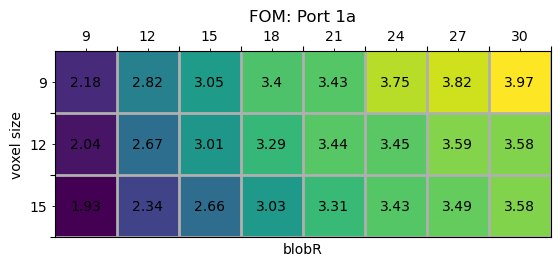

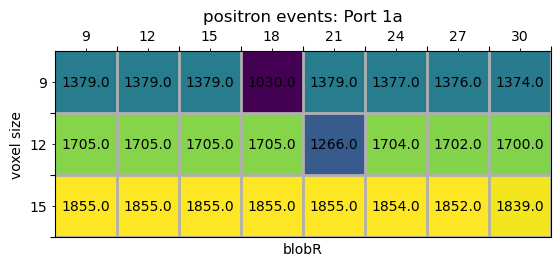

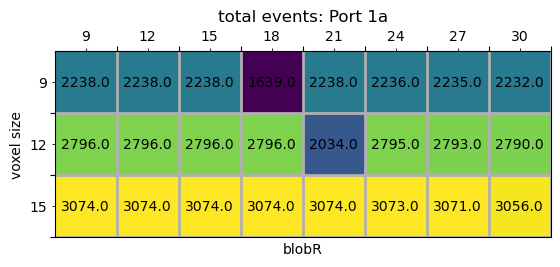

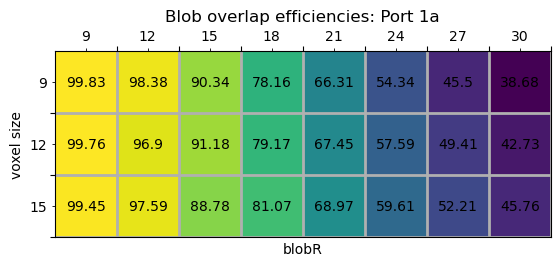

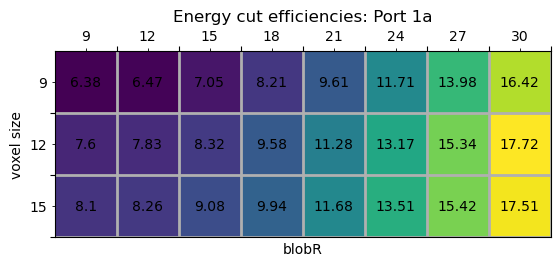

In [26]:
for i in range(len(data_groups)):
    name = data_groups[i].split("/")[-1][:-3]
    name = name[16:]
    name2 = "Port " + name
    print(name)
    scrape_any_data_new(data_groups[i], 'FOM_MAX - blob2_E_val (MeV)', 'Relative Efficiency', plot_title = "FOM: " + name2)
    scrape_any_data_new(data_groups[i], 'pos_evt - all_evt', 'Relative Efficiency', plot_title = "positron events: " + name2)
    scrape_any_data_new(data_groups[i], 'pos_evt - all_evt', 'Relative Events', plot_title = "total events: " + name2)
    scrape_any_data_new(data_groups[i], 'Blob overlap cuts', 'Relative Efficiency', plot_title = "Blob overlap efficiencies: " + name2)
    scrape_any_data_new(data_groups[i], 'Energy cuts', 'Relative Efficiency', plot_title = "Energy cut efficiencies: " + name2)

In [ ]:
# collect blob overlap and energy cut efficiencies.
